# Visualization and Exploration of Dataset

In [1]:
#Package imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

#Helper functions for specific feature engineering used in paper and NN decomp alg
import helpers

Text(0.5, 1.0, 'Parity Plot (with 1 Standard Deviation Range)')

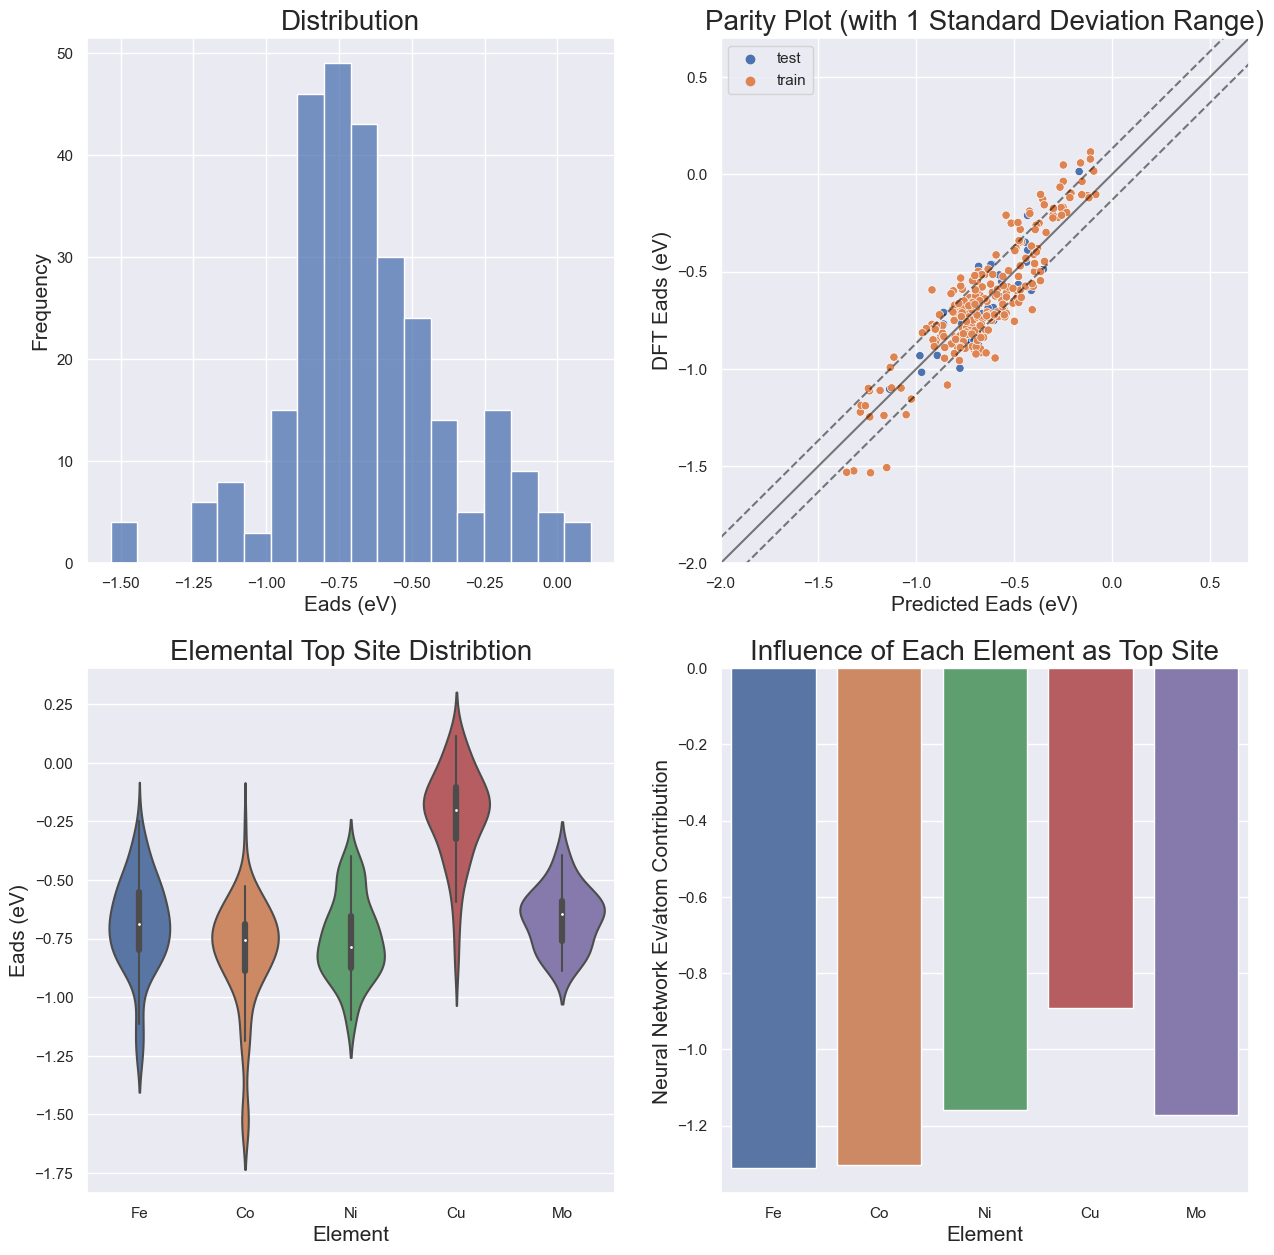

In [3]:
#1 - Read in CO,CHO or COOH dataset, select 1 of the 3 adsorbates to visualize
df = pd.read_csv('All_data.csv')
df_COOH = df[df['Adsorbate']=='COOH']

#2 - Create Dictionnary for chemical descriptors you wish to use
element_dict = {'Co': [9,4,1.88],'Fe': [8,4,1.83],'Cu': [11,4,1.9],'Ni': [10,4,1.91],'Mo': [6,5,2.16]} 

#3 - Initialize model_analysis class
model_analysis = helpers.Model_analyzer(element_dict,
                                        10,
                                        df_COOH.drop(columns=['Adsorbate','Eads']))

#4 - Model Training + Fitting (simplest model possible)
x = model_analysis.feature_embedding() #create inputs using chemical descriptor dict.
y = df_COOH['Eads']

#5 - Read in COOH atomic influences extract from 'Neural_Net_Decomposition_Method' Notebook
vis = pd.read_csv('site_infs.csv')
vis = vis[vis['Adsorbate']=='COOH']
vis = vis[vis['Site']==1]

#6 - Model Training + Fitting just to provide a parity plot
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15)

model = helpers.MyModel()
model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
h = model.fit(x_train, y_train, epochs=3000, callbacks=[],verbose=0 )

#6.5 - Calculate std of NN predictions for parity plot 

label=[]

test = [i[0] for i in model.predict(x_test).tolist()]
[label.append('test') for l in test]

train = [i[0] for i in model.predict(x_train).tolist()]
[label.append('train') for l in train]

pred_y = test + train
real_y =list(y_test)+list(y_train)
df = pd.DataFrame(data={'predict': pred_y, 'real': real_y,'label':label})
std_dev= np.std(df['predict'] - df['real'])

#Upper and low bounds for parity plot
df1 = pd.DataFrame(data={'x':[-4,4],'lines': [-4-std_dev,4-std_dev],'hue':['low','low']})
df2 = pd.DataFrame(data={'x':[-4,4],'lines': [-4+std_dev,4+std_dev],'hue':['up','up']})

#7 - Data visualization summarizing Distribution, NN performance, Element influences
sns.set_theme()
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

x1=sns.barplot(ax=axes[1, 1],x="Element", y="Ev/atom", data=vis,order=['Fe','Co','Ni','Cu','Mo'])
x1.set_xlabel("Element", fontsize = 15)
x1.set_ylabel("Neural Network Ev/atom Contribution", fontsize = 15)
x1.set_title("Influence of Each Element as Top Site", fontsize = 20)

x2=sns.violinplot(ax=axes[1, 0],x=df_COOH.columns[0], y="Eads", data=df_COOH,order=[ 'Fe','Co','Ni','Cu','Mo'])
x2.set_xlabel("Element", fontsize = 15)
x2.set_ylabel("Eads (eV)", fontsize = 15)
x2.set_title("Elemental Top Site Distribtion", fontsize = 20)

x3=sns.histplot(ax=axes[0, 0],data=df_COOH, x='Eads')
x3.set_xlabel("Eads (eV)", fontsize = 15)
x3.set_ylabel("Frequency", fontsize = 15)
x3.set_title("Distribution", fontsize = 20)

x4=sns.scatterplot(ax=axes[0,1],data=df, x='predict',y='real',hue='label',marker='o', color='b')
x4.set(xlim=(-2,0.7))
x4.set(ylim=(-2,0.7))
x4.plot([-4,4],[-4,4],color='black',alpha=0.5) 
x4=sns.lineplot(ax=axes[0,1],x='x',y='lines',data=df1,color='black',alpha  = 0.5)
x4.lines[1].set_linestyle("--")
x4=sns.lineplot(ax=axes[0,1],x='x',y='lines',data=df2,color='black',alpha  = 0.5)
x4.lines[2].set_linestyle("--")
x4.set_xlabel("Predicted Eads (eV)", fontsize = 15)
x4.set_ylabel("DFT Eads (eV)", fontsize = 15)
x4.set_title("Parity Plot (with 1 Standard Deviation Range)", fontsize = 20)
#plt.savefig('fig')